In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('kang_count.h5ad')

In [5]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [6]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [7]:
adata.obs['study'] = 'Kang'

In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True)

In [9]:
select_terms = adata.varm['I'].sum(0)>12

In [10]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [11]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [12]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [13]:
rm_in_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN']
ix_f = []
for t in rm_in_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [14]:
#genes_rm = {}
#for i, term in enumerate(rm_in_terms):
#    term_genes = adata.varm['I'][:, ix_f[i]]
#    sz_rm = int(term_genes.sum() * 0.15)
#    sel_rm = np.random.choice(np.where(term_genes)[0], sz_rm, replace=False)
#    genes_rm[term] = sel_rm
#    term_genes[sel_rm] = 0

In [15]:
genes_rm = {}
for i, term in enumerate(rm_in_terms):
    term_genes = adata.varm['I'][:, ix_f[i]]
    sel_rm = np.isin(adata.var_names, ['ISG15', 'ISG20', 'IFIT2'])
    genes_rm[term] = sel_rm
    term_genes[sel_rm] = 0

### Create TRVAE model and train it on reference dataset

In [140]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    n_ext_decoder=0,
    n_expand_encoder=0,
    soft_mask=True,
    use_hsic=False,
    hsic_one_vs_all=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1981 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 267
Decoder Architecture:
	Cond layer in, ext, cond, out and :  267 0 1 1981
	with soft mask.


In [141]:
ALPHA = 0.6

In [142]:
OMEGA = None

In [143]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_l1=0.09,
    gamma_ext=None,
    gamma_epoch_anneal=None,
    alpha_kl=0.06,
    beta=None,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    print_n_deactive=True,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.0621
-------------------
 |--------------------| 0.5%  - epoch_loss:  549.16 - epoch_recon_loss:  549.16 - epoch_kl_loss:  330.64 - val_loss:  470.89 - val_recon_loss:  470.89 - val_kl_loss:  500.58
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.1245
-------------------
 |--------------------| 1.0%  - epoch_loss:  461.23 - epoch_recon_loss:  460.88 - epoch_kl_loss:  586.18 - val_loss:  451.51 - val_recon_loss:  451.11 - val_kl_loss:  674.25
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.1615
-------------------
 |--------------------| 1.5%  - epoch_loss:  451.79 - epoch_recon_loss:  450.91 - epoch_kl_loss:  731.54 - val_loss:  444.43 - val_recon_loss:  443.47 - val_kl_loss:  798.14
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.1558
-------------------
 |----------------

Share of deactivated inactive genes: 0.3633
-------------------
 |██------------------| 14.5%  - epoch_loss:  411.27 - epoch_recon_loss:  403.71 - epoch_kl_loss:  450.05 - val_loss:  414.35 - val_recon_loss:  406.81 - val_kl_loss:  448.42
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3587
-------------------
 |███-----------------| 15.0%  - epoch_loss:  412.91 - epoch_recon_loss:  405.24 - epoch_kl_loss:  440.79 - val_loss:  414.77 - val_recon_loss:  407.27 - val_kl_loss:  430.82
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3607
-------------------
 |███-----------------| 15.5%  - epoch_loss:  413.22 - epoch_recon_loss:  405.45 - epoch_kl_loss:  431.59 - val_loss:  413.86 - val_recon_loss:  406.16 - val_kl_loss:  427.86
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3548
-------------------
 |███-----------------| 16.0%  - epoch_loss:  412.02 - epoch_recon

 |█████---------------| 28.5%  - epoch_loss:  407.94 - epoch_recon_loss:  397.99 - epoch_kl_loss:  295.85 - val_loss:  407.86 - val_recon_loss:  398.16 - val_kl_loss:  288.72
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3219
-------------------
 |█████---------------| 29.0%  - epoch_loss:  405.11 - epoch_recon_loss:  395.07 - epoch_kl_loss:  293.54 - val_loss:  408.70 - val_recon_loss:  398.94 - val_kl_loss:  285.40
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3269
-------------------
 |█████---------------| 29.5%  - epoch_loss:  406.51 - epoch_recon_loss:  396.41 - epoch_kl_loss:  290.18 - val_loss:  408.68 - val_recon_loss:  398.84 - val_kl_loss:  282.74
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3280
-------------------
 |██████--------------| 30.0%  - epoch_loss:  407.35 - epoch_recon_loss:  397.20 - epoch_kl_loss:  286.62 - val_loss:  407.17 - va

 |████████------------| 42.5%  - epoch_loss:  404.94 - epoch_recon_loss:  393.40 - epoch_kl_loss:  229.11 - val_loss:  405.33 - val_recon_loss:  394.18 - val_kl_loss:  221.35
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3264
-------------------
 |████████------------| 43.0%  - epoch_loss:  402.01 - epoch_recon_loss:  390.50 - epoch_kl_loss:  225.59 - val_loss:  405.26 - val_recon_loss:  394.03 - val_kl_loss:  220.08
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3197
-------------------
 |████████------------| 43.5%  - epoch_loss:  406.51 - epoch_recon_loss:  394.87 - epoch_kl_loss:  225.64 - val_loss:  405.63 - val_recon_loss:  394.49 - val_kl_loss:  216.03
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3189
-------------------
 |████████------------| 44.0%  - epoch_loss:  405.11 - epoch_recon_loss:  393.45 - epoch_kl_loss:  223.47 - val_loss:  404.90 - va

 |███████████---------| 56.5%  - epoch_loss:  400.62 - epoch_recon_loss:  388.86 - epoch_kl_loss:  196.05 - val_loss:  403.61 - val_recon_loss:  392.21 - val_kl_loss:  189.91
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3215
-------------------
 |███████████---------| 57.0%  - epoch_loss:  399.78 - epoch_recon_loss:  388.06 - epoch_kl_loss:  195.42 - val_loss:  403.05 - val_recon_loss:  391.65 - val_kl_loss:  190.01
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3237
-------------------
 |███████████---------| 57.5%  - epoch_loss:  402.30 - epoch_recon_loss:  390.54 - epoch_kl_loss:  196.01 - val_loss:  403.74 - val_recon_loss:  392.44 - val_kl_loss:  188.40
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3196
-------------------
 |███████████---------| 58.0%  - epoch_loss:  402.09 - epoch_recon_loss:  390.37 - epoch_kl_loss:  195.32 - val_loss:  404.77 - va

 |██████████████------| 70.5%  - epoch_loss:  399.53 - epoch_recon_loss:  387.98 - epoch_kl_loss:  192.55 - val_loss:  402.44 - val_recon_loss:  391.18 - val_kl_loss:  187.63
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3211
-------------------
 |██████████████------| 71.0%  - epoch_loss:  402.44 - epoch_recon_loss:  390.85 - epoch_kl_loss:  193.03 - val_loss:  401.71 - val_recon_loss:  390.50 - val_kl_loss:  186.86
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3173
-------------------
 |██████████████------| 71.5%  - epoch_loss:  399.88 - epoch_recon_loss:  388.32 - epoch_kl_loss:  192.68 - val_loss:  402.79 - val_recon_loss:  391.64 - val_kl_loss:  185.88
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3161
-------------------
 |██████████████------| 72.0%  - epoch_loss:  400.64 - epoch_recon_loss:  389.10 - epoch_kl_loss:  192.36 - val_loss:  401.54 - va

 |████████████████----| 84.5%  - epoch_loss:  397.53 - epoch_recon_loss:  385.81 - epoch_kl_loss:  195.31 - val_loss:  401.07 - val_recon_loss:  389.81 - val_kl_loss:  187.69
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3012
-------------------
 |█████████████████---| 85.0%  - epoch_loss:  396.87 - epoch_recon_loss:  385.19 - epoch_kl_loss:  194.74 - val_loss:  400.94 - val_recon_loss:  389.65 - val_kl_loss:  188.06
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3104
-------------------
 |█████████████████---| 85.5%  - epoch_loss:  396.09 - epoch_recon_loss:  384.41 - epoch_kl_loss:  194.59 - val_loss:  400.70 - val_recon_loss:  389.43 - val_kl_loss:  187.94
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.3111
-------------------
 |█████████████████---| 86.0%  - epoch_loss:  397.49 - epoch_recon_loss:  385.81 - epoch_kl_loss:  194.73 - val_loss:  401.03 - va

In [144]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [145]:
terms = adata.uns['terms'].copy()

In [146]:
print('Inactive terms:')
[term for i, term in enumerate(terms) if inactive_idx[i]]

Inactive terms:


[]

In [147]:
MEAN = False

In [148]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [149]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [150]:
sc.tl.umap(adata)

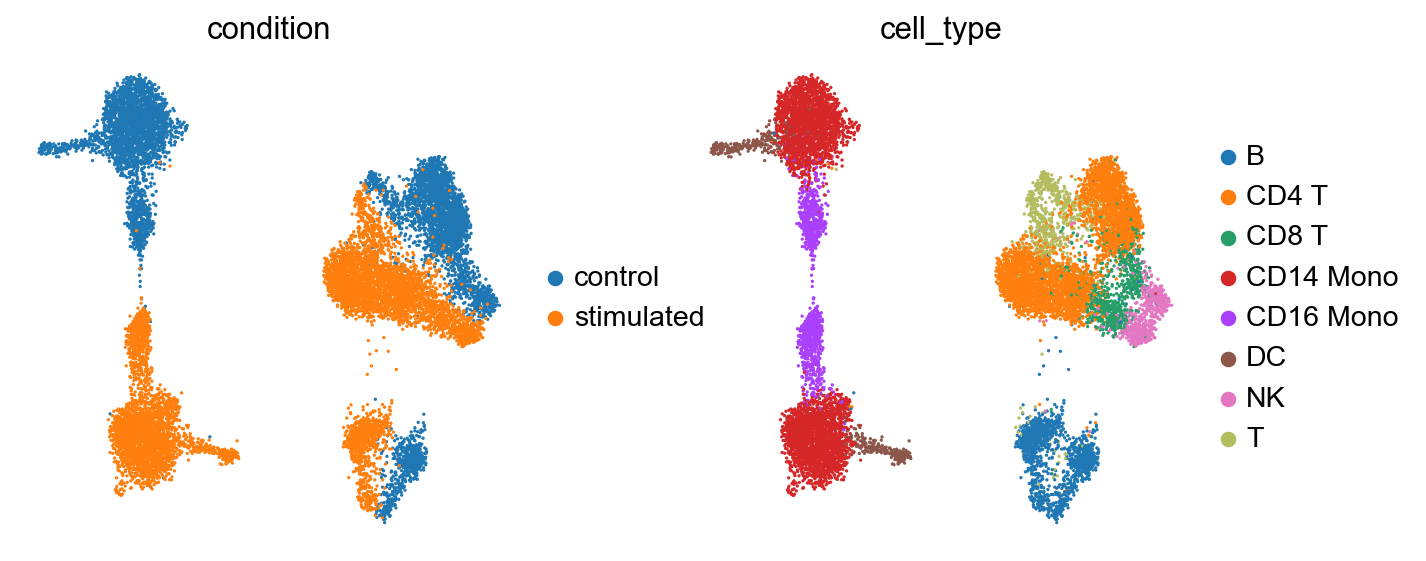

In [151]:
sc.pl.umap(adata, color=['condition', 'cell_type'], frameon=False)

In [152]:
for i, ix in enumerate(ix_f):
    tname = rm_in_terms[i]
    print(tname)
    term = intr_cvae.model.decoder.L0.expr_L.weight.data[:, ix].abs().cpu().numpy()
    srt = np.argsort(term)[::-1]
    term = term > 0
    genes_from_term = np.isin(adata.var_names[srt[:20]], adata.var_names[adata.varm['I'][:, ix].astype(bool)]).sum()
    print('Total size before training:', adata.varm['I'][:, ix].sum())
    print('Total size after training:', term.sum().item())
    print('Genes from the term in top 20:', genes_from_term)
    print('Numbr of deleted genes:', )
    print('Recovered genes number:', term[genes_rm[tname]].sum().item())
    print('Recovered in top 20:', np.isin(srt[:20], np.where(genes_rm[tname])[0]).sum())

INTERFERON_SIGNALING
Total size before training: 83
Total size after training: 1276
Genes from the term in top 20: 19
Numbr of deleted genes:
Recovered genes number: 3
Recovered in top 20: 0
INTERFERON_ALPHA_BETA_SIGNALIN
Total size before training: 30
Total size after training: 1289
Genes from the term in top 20: 7
Numbr of deleted genes:
Recovered genes number: 2
Recovered in top 20: 0


In [73]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [79]:
# select term name here
idx = [terms.index(term) for term in ['unannotated_2', 'SIGNALING_BY_THE_B_CELL_RECEPT']]

In [80]:
latents = intr_cvae.get_latent(mean=MEAN)[:, idx]

In [81]:
adata.obs['unannotated'] = latents[:, 0]
adata.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]

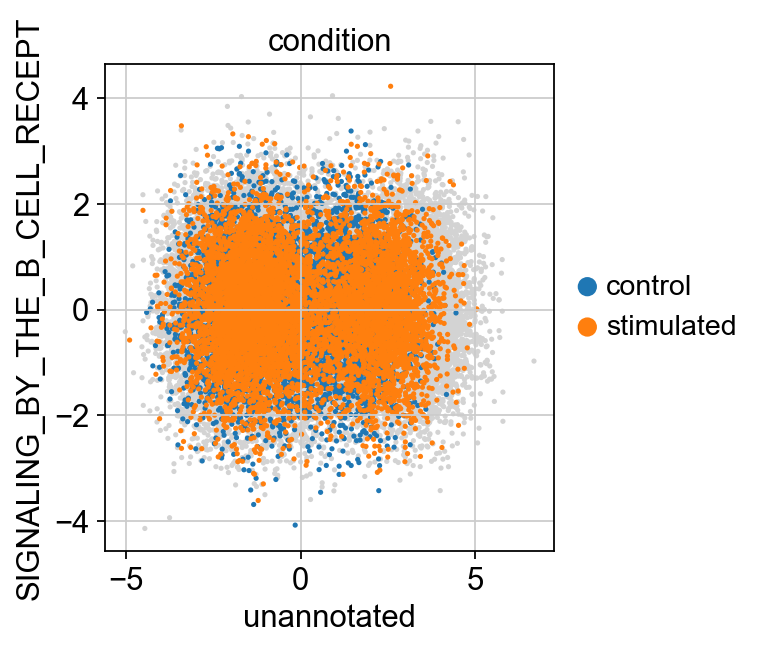

In [82]:
sc.pl.scatter(adata, x='unannotated', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

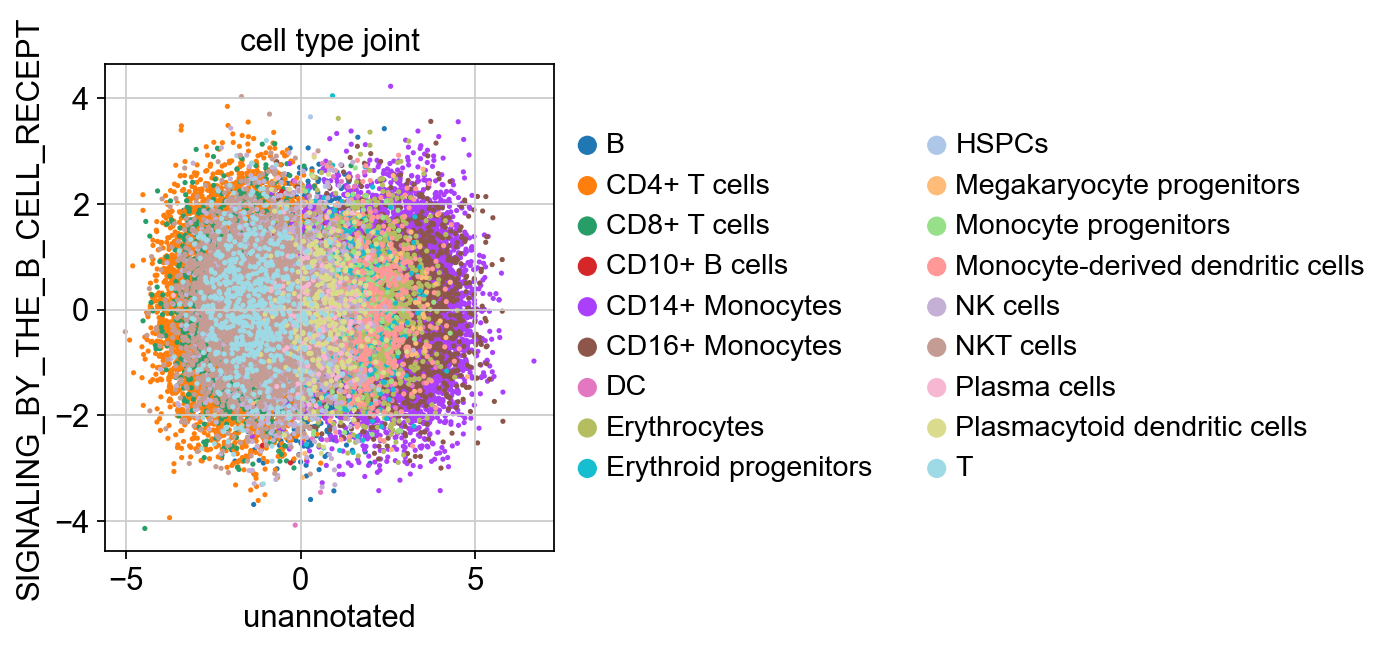

In [83]:
sc.pl.scatter(adata, x='unannotated', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type_joint', size=22)

In [44]:
IFN_GENES = ['ADAR','ARIH1', 'B2M','CAMK2D', 'CD44','CIITA', 'DDX58', 'EGR1', 'EIF2AK2', 'EIF4A3',
             'EIF4E', 'EIF4E3', 'EIF4G3', 'FCGR1A', 'FCGR1B', 'GBP1', 'GBP2', 'GBP4', 'GBP5', 'HERC5', 
             'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DRB1', 
             'HLA-DRB5', 'HLA-F', 'HLA-G', 'ICAM1', 'IFI27', 'IFI35', 'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 
             'IFITM1', 'IFITM2', 'IFITM3', 'IFNAR1', 'IFNAR2', 'IFNG', 'IFNGR1', 'IFNGR2', 'IRF1', 'IRF2', 
             'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'JAK1', 'JAK2', 'KPNA1', 
             'KPNA2', 'MAPK3', 'MT2A', 'MX1', 'MX2', 'NCAM1', 'NUP205', 'NUP210', 'NUP214', 'NUP50', 
             'NUP88', 'NUPL2', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'PIAS1', 'PLCG1', 'PML', 'PPM1B', 'PRKCD', 
             'PTAFR', 'PTPN1', 'PTPN6', 'RANBP2', 'SOCS1', 'SOCS3', 'STAT1', 'STAT2', 'TRIM25', 'TYK2',
             'UBA7', 'USP18', 'XAF1']

In [45]:
IFN_A_B_GENES = ['ISG15', 'IFI6', 'JAK1', 'GBP2', 'ADAR', 'STAT1', 'IRF2', 'IRF1', 'EGR1', 'IRF4', 
                 'HLA-F', 'HLA-G', 'HLA-A', 'HLA-C', 'HLA-B', 'IRF5', 'IFITM2', 'IFITM1', 'IFITM3', 
                 'IRF7', 'IFIT2', 'IFIT3', 'IFIT1', 'PTPN6', 'STAT2', 'OAS1', 'OAS3', 'OAS2', 'OASL',
                 'IRF9', 'IFI27', 'ISG20', 'SOCS1', 'IRF8', 'XAF1', 'IFI35', 'SOCS3', 'PTPN1', 'TYK2', 
                 'IRF3', 'USP18', 'IFNAR2', 'IFNAR1', 'MX2', 'MX1']

In [333]:
unann_idx = 0

In [334]:
unann_genes = adata.var_names[(intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx]>0).cpu().numpy()].tolist()

In [335]:
len(set(unann_genes).intersection(IFN_GENES))

43

In [336]:
len(set(unann_genes).intersection(IFN_A_B_GENES))

24

In [337]:
srt = np.argsort(intr_cvae.model.decoder.L0.ext_L.weight.data.abs()[:, unann_idx].cpu().numpy())[::-1]

In [338]:
unann_genes_top = adata.var_names[srt[:100]].tolist()

In [339]:
len(set(unann_genes_top).intersection(IFN_GENES))

19

In [340]:
len(set(unann_genes_top).intersection(IFN_A_B_GENES))

10

In [341]:
# monocyte related

In [346]:
len(set(unann_genes_top).intersection(intr_cvae.terms_genes()['SIGNALING_BY_GPCR']))

11

In [348]:
len(set(unann_genes_top).intersection(intr_cvae.terms_genes()['METABOLISM_OF_CARBOHYDRATES']))

4

In [350]:
len(set(unann_genes_top).intersection(intr_cvae.terms_genes()['METABOLISM_OF_AMINO_ACIDS_AND_']))

5